In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import scipy

In [4]:
from libs.plotting import plot_lcs
from astropy.table import Table

### Load data

In [5]:
from dataset import radio_3c273, gev_3c273, coincidence_mask_3c273

from dataset import radio_3c273_orig

from dataset import coincidence_checker
import matplotlib.pyplot as plt

### Define response profile and convolution routine

In [6]:
def profile_st(x, Amp, t_rise, t_fall, t_shift):
    t = x - t_shift
    return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))

def convolve_arrays_sigma(v1, v2, dv1):
    v1, v2, dv1 = np.array(v1), np.array(v2), np.array(dv1)
    r = np.convolve(v1, v2)
    dr2 = np.convolve(dv1 ** 2, v2 ** 2)
    return r, np.sqrt(dr2)

### Define fit configuration and fitting routines

In [7]:
def prepare_fit(s_data_ds, r_data_ds, bin_size, fit_roi, time_start=None, noplot=False):
    s_data = s_data_ds
    r_data = r_data_ds
    
    s_m, r_m = coincidence_checker(s_data, r_data, bin_size=bin_size)
    
    sd = Table({i:s_data_ds[i][s_m] for i in s_data_ds.columns})
    sd.meta = s_data_ds.meta
    for c in s_data_ds.columns:
        sd[c].unit = s_data_ds[c].unit
    
    rd = Table({i:r_data_ds[i][r_m] for i in r_data_ds.columns})
    rd.meta = r_data_ds.meta
    for c in r_data_ds.columns:
        rd[c].unit = r_data_ds[c].unit
    
    if not noplot:
        plot_lcs(sd, rd, extra_data=[s_data_ds, r_data_ds], highlights=[None, fit_roi], figsize=(10, 6))
    return s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd


def get_fit(params, 
            configuration, 
            profile_func, 
            t_shift=None, 
            const_flux_present=False, 
            all_uncertainties=False, 
            exclude_roi=[], 
            plot_data=False, 
            curvefit=False, 
            syn_delay=0, 
            result=False,  
            ylims=None, 
            start_time=None, 
            highlight=None,
            plot_timerange=None,
            dst_data=None, 
            color='black',
            extra_data=None,
            extra_color='#1f77b4', #'#11265b',
            filename='tmp.png',
            flare_tuning = None,
            background=None,
            extra_plot=None,
            get_dof = False,
            plot_flares=False
           ):
    s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd = configuration
    s_t, s_f, s_df = s_data['tc'], s_data['f'], s_data['df']
    r_t, r_f, r_df = r_data['tc'], r_data['f'], r_data['df']
    
    const_flux = 0
    if const_flux_present:
        const_flux = params[-1]
        params = params[:-1]        
    if t_shift is not None:
        params = [*params] + [t_shift]
    prof = profile_func(s_t - min(s_t), *params)
    _params = [i for i in params]
    A0 = params[0]
    syn_t = s_t
    syn_f = np.zeros_like(s_f)
    syn_df = np.zeros_like(s_df)
    if flare_tuning is None:
        syn = convolve_arrays_sigma(s_f.copy(), prof, s_df)
        syn_f = syn[0][:len(s_f)] + const_flux
        syn_df = syn[1][:len(s_f)]
    else:
        fig = None
        if plot_flares:
            fig = plt.figure(figsize=(15,5))
        for f in flare_tuning:
            _time_range, amplitude = f
            _tmp_s_f = np.zeros_like(s_f)
            _tmp_s_df = np.zeros_like(s_df)
            m = np.logical_and(syn_t > _time_range[0], syn_t <= _time_range[1])
            _tmp_s_f[m] = s_f.copy()[m]
            _tmp_s_df[m] = s_df.copy()[m]
            _params[0] = A0 * amplitude
            prof = profile_func(s_t - min(s_t), *_params)
            syn = convolve_arrays_sigma(_tmp_s_f, prof, _tmp_s_df)
            syn_f += syn[0][:len(s_f)]
            syn_df += syn[1][:len(s_f)]**2
            if plot_flares:
                plt.plot(s_t, syn[0][:len(s_f)] + const_flux, '.', label="%s" % _time_range)
        syn_t = s_t   
        if background is not None:
            syn_f += background(s_t, const_flux)
        else:
            syn_f += const_flux
        syn_df = 0*np.sqrt(syn_df)
        if plot_flares:
            plt.legend()
            plt.show()
        
    roi_mask = np.logical_and(r_t[r_m] >= fit_roi[0], r_t[r_m] <= fit_roi[1])
    
    _r_t = r_t[r_m][roi_mask]
    _r_f = r_f[r_m][roi_mask]
    _r_df = r_df[r_m][roi_mask]
    
    _s_t = syn_t[s_m][roi_mask]
    _s_f = syn_f[s_m][roi_mask]
    _s_df = syn_df[s_m][roi_mask]
    
    if curvefit:
        return np.column_stack([_r_t, _r_f, _r_df]), np.column_stack([_s_t, _s_f, _s_df])
    
    delta = _r_df
    if all_uncertainties:
        delta = np.sqrt(_r_df**2 + _s_df**2)
    
    xi = ((_s_f - _r_f)/delta)**2
    xi_t = _s_t
    for p in exclude_roi:
        m = np.logical_and(xi_t >= p[0], xi_t <= p[1])
        xi = xi[~m]
        xi_t = xi_t[~m]
    
    dof = len(xi) - len(params) - (1 if const_flux_present else 0)
    chi2 = np.sum(xi)
    
    if get_dof:
        return chi2/dof, dof
        
    if not plot_data:
        #clear_output(wait=True)
        #display("chi2 = %s (%s), params = %s, delta_t = %s" % (chi2, len(xi), np.array(params), t_shift))
        return chi2/dof
    else:
        p = [i for i in params]
        if const_flux_present:
            p += [const_flux]
            
        print("chi2/dof = %s/%s = %s, params = %s, t_shift=%s" % (chi2, dof, chi2/dof, str(p), t_shift))
    

        syn_full = Table({'tc' : syn_t + syn_delay, 'f' : syn_f, 'df' : syn_df})
        syn_full.meta['title'] = "Synthetic LC"
        syn_full.meta['f_units'] = "Jy"

        sn = Table({'tc' : _s_t + syn_delay, 'f' : _s_f, 'df' : _s_df})
        sn.meta['title'] = "Synthetic LC"
        sn.meta['f_units'] = "Jy"

                
        #plot_lcs(sd, sn, rd, extra_data=[s_data_ds, syn_full, r_data_ds], highlights=[None, fit_roi, fit_roi], figsize=(10, 10), filename='images/gev_syn_radio.eps')
        
        _highlight = fit_roi if highlight is None else highlight
        _dst_data = rd if dst_data is None else dst_data
        
        
        
        def inset_creator(ax):
            x = np.linspace(0, 700, 1000)
            A, t_rise, t_decay, f_const = 197765.3421157885, 19.24416937907919, 42.883458356259524, 26.973314037084446
            delta_t = 255
            p = profile_func(x - min(x), *params)
            ax.plot(x, p/np.max(p))
            ax.set_ylabel("$S/S_{max}$")
            ax.set_xlabel('$t$ (d)')

        
        plot_lcs(s_data, sn, _dst_data, extra_data=extra_data, extra_plot=extra_plot, highlights=[None, _highlight, _highlight, None], extra_color=extra_color, color=color, figsize=(11, 9), ylims=ylims, timerange=plot_timerange, filename=filename, inset_creator=inset_creator, inset_id=1)
       
        return sd, sn, rd, chi2, dof, _r_t, _r_f, _r_df, _s_t, _s_f, _s_df, syn_full

### Perform de-trending

In [8]:
from scipy.signal import savgol_filter
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import time

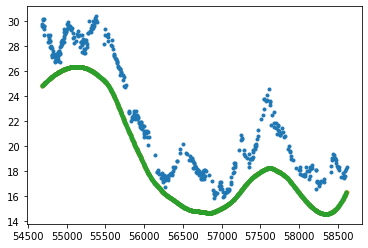

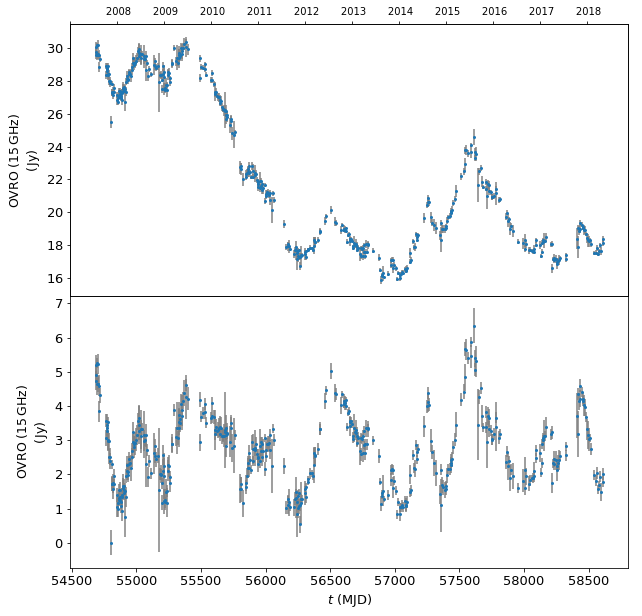

In [9]:
def data_resample(data, dt=3):

    obs_int = max(data['tc']) - min(data['tc'])
    n_samples = obs_int / dt
    samples = min(data['tc']) + np.arange(0, obs_int, dt)
    resampled_values = np.interp(samples, data['tc'], data['f'])
    return samples, resampled_values

def detrending(data, window=501, polyorder=3, dt=3):
    new_samples, resampled = data_resample(data, dt=dt)
    filtered = savgol_filter(resampled, window, polyorder)
    subtracted = data['f'] - np.interp(data['tc'], new_samples, filtered)
    m = np.min(subtracted)
    return data['tc'], subtracted - m, data['tc'], data['f'] - subtracted + m, new_samples, filtered + m
    #return data['tc'], subtracted, data['tc'], data['f'] - subtracted, new_samples, filtered


radio_3c273_dt_data = detrending(radio_3c273, dt=3)
plt.plot(radio_3c273['tc'], radio_3c273['f'], '.')
plt.plot(radio_3c273_dt_data[2], radio_3c273_dt_data[3], '.')
plt.plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], '.')
plt.show()

radio_3c273_dt = Table({k:radio_3c273[k] for k in radio_3c273.columns})
radio_3c273_dt['f'] = radio_3c273_dt_data[1]
radio_3c273_dt.meta = radio_3c273.meta
for c in radio_3c273.columns:
    radio_3c273_dt[c].unit = radio_3c273[c].unit
    
plot_lcs(radio_3c273, radio_3c273_dt)

### Define fitting configurations: initial flare fitting, amplitude adjustment fitting

3C 273 using UL


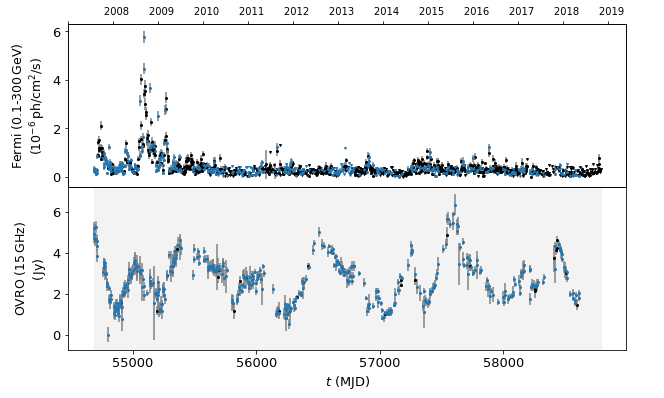

3C 273 using UL


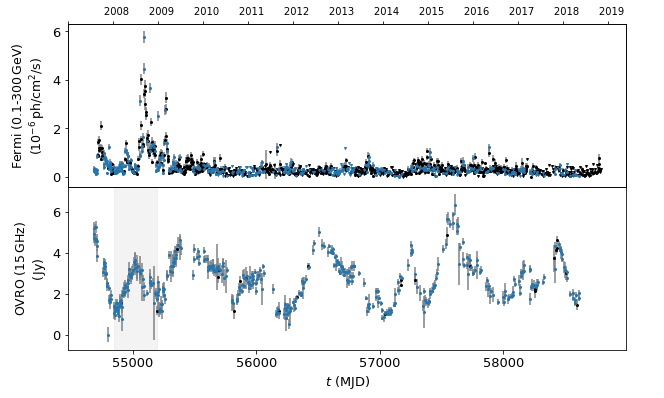

3C 273 using UL


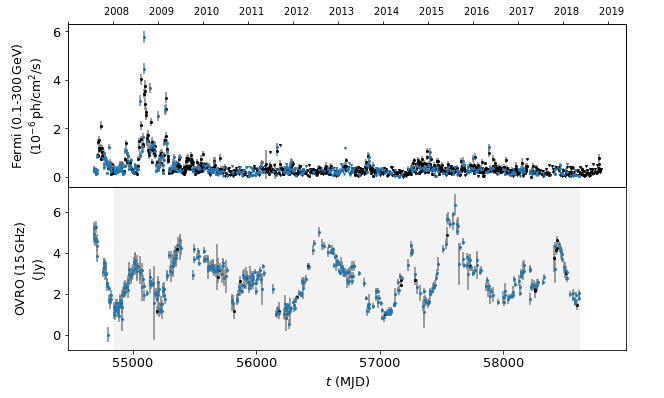

In [10]:
full_range=gev_3c273.meta['timerange']
flaring_period_1 = [54850, 55200]
flaring_period_X = [54850, radio_3c273.meta['timerange'][1]]

con_3c273_f0 = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=full_range)
con_3c273_f1 = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=flaring_period_1)
con_3c273_fX = prepare_fit(gev_3c273, radio_3c273_dt, bin_size=3, fit_roi=flaring_period_X)

### Perform fitting of the flare

In [11]:
bounds = [ # no bounds really
    [1e-12, 1e12], # Amp
    [1e-12, 1e12], # t_rise
    [1e-12, 1e12], # t_fall
    [-1e12, 1e12], # flux_const
]
methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
b_methods = ["L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr",]

res_7d = []
counter = 0
for r in np.arange(225, 300, 0.3): # using step 1/10 of the binning
    _v = optimize.minimize(
                              get_fit,
                              [97765.3421157885, 19.24416937907919, 42.883458356259524, 15.973314037084446], # random guess
                              args = (con_3c273_f1, profile_st, r, True, False), #configuration, profile_function, 
                                                                                 # t_rise time, is_const_flux_present, all_uncertainties
                              method=b_methods[4], bounds=bounds,
                              options={'disp': False, 'maxiter': 10000, 'xtol': 1e-09}
                            )
    time.sleep(0.1)
    if counter % 10 == 0:
        clear_output(wait=True)
    counter+=1
    print(r, "%.3f" % _v.fun, ", ".join(["%.3f" % i for i in _v.x]))
    res_7d.append([r, _v])

297.00000000000273 1.766 159027.458, 10.961, 13.836, 1.150
297.30000000000274 1.771 158670.163, 10.888, 13.707, 1.149
297.60000000000275 1.776 158302.880, 10.817, 13.579, 1.149
297.90000000000276 1.780 157971.437, 10.741, 13.447, 1.148
298.2000000000028 1.785 157550.443, 10.673, 13.325, 1.148
298.5000000000028 1.790 157196.554, 10.598, 13.195, 1.147
298.8000000000028 1.795 156682.326, 10.536, 13.084, 1.146
299.1000000000028 1.800 156435.244, 10.451, 12.943, 1.146
299.4000000000028 1.805 155928.810, 10.387, 12.831, 1.145
299.70000000000283 1.810 155675.075, 10.302, 12.691, 1.145


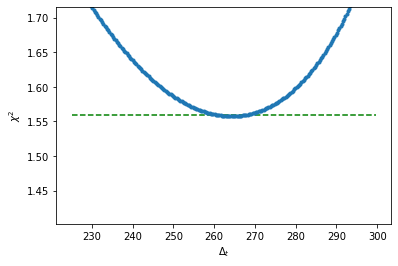

items:  26
260.40 [171938.05758442383, 16.274888137055537, 32.3806992742562, 1.2105454056340048] 1.5163704074969688
260.70 [172084.37651544673, 16.26060251708072, 32.206258993723196, 1.2102695615177446] 1.516080314595255
261.00 [172204.80624872356, 16.24777053150864, 32.036290209750696, 1.2099887619996161] 1.51582059641787
261.30 [172365.06925680692, 16.23084925864538, 31.858982411440582, 1.209704209264266] 1.515574375670673
261.60 [172502.53828815537, 16.21511044917476, 31.68557235466022, 1.2094149128690046] 1.515357904378687
261.90 [172633.26542505648, 16.199199376087908, 31.513167168202088, 1.2091209224738415] 1.515167081201491
262.20 [172761.760187857, 16.182730909508848, 31.34095393477257, 1.2088224881090432] 1.5150008544907656
262.50 [172890.27087631245, 16.165509943120533, 31.16853120443129, 1.2085199521042624] 1.51485876625835
262.80 [173010.40156321254, 16.148241583118683, 30.99736992771848, 1.2082125605775793] 1.5147429725674686
263.10 [173127.79419741497, 16.13044767430457, 

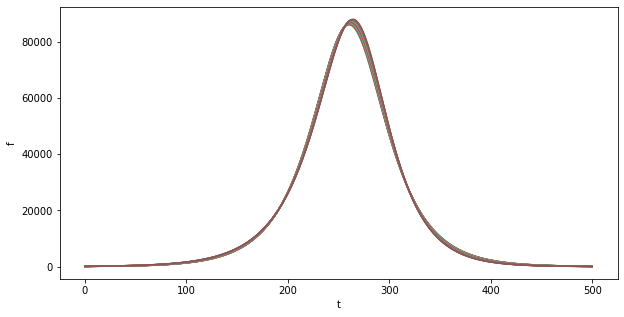

Best fit parameters:  [1.73554736e+05 1.60551982e+01 3.01479791e+01 1.20660762e+00]
Delta t:  264.3000000000015


In [21]:
data = res_7d

min_chi2dof, max_chi2dof = 1.4, 1.56
ts, xs, fun = np.array([i[0] for i in data]), np.array([i[1].x for i in data]), np.array([i[1].fun for i in data])
plot_y_limits = [0.9*np.min(fun), 1.1*max_chi2dof]

plt.plot(ts, fun, '.')
plt.hlines(max_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='dashed')
plt.hlines(min_chi2dof, np.min(ts), np.max(ts), color='green', linestyle='solid')
plt.ylim(plot_y_limits)
plt.xlabel("$\Delta_t$")
plt.ylabel("$\chi^2$")
plt.show()

bf_params = xs[np.argmin(fun)]
bf_delta_t = ts[np.argmin(fun)]

m = np.logical_and(fun >= min_chi2dof, fun <= max_chi2dof)
xs, ts = xs[m], ts[m]
_f = fun[m]
print("items: ", len(xs))
fig = plt.figure(figsize=(10, 5))
x = np.linspace(0, 500, 1000)
for t, f, v in zip(ts, _f, xs):
    #params = list(v) + [t]
    #const_flux = 0
    #const_flux_present=False
    params = list(v[:-1]) + [t]
    const_flux = v[-1]
    const_flux_present=True
    plt.plot(x, profile_st(x, *params) + const_flux, '-')
    xi2 = get_fit(v, con_3c273_f1, profile_st, t, const_flux_present, all_uncertainties=True)
    print("%.2f" % t, list(v), xi2)
plt.xlabel("t")
plt.ylabel("f")
plt.show()

print("Best fit parameters: ", bf_params)
print("Delta t: ", bf_delta_t)

### Estimate parameters uncertainties

In [13]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
#
params = list([bf_delta_t]) + list(bf_params)
print(params)
x0, dof = get_fit(params[1:], con_3c273_f1, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_3c273_f1, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")

[264.3000000000015, 173554.73619723803, 16.055198211301636, 30.14797905248275, 1.2066076170811506]
264.3000000000015 -6.481831831831926 +6.217267267267289 || 257.81816816816956 & 270.5172672672688
173554.73619723803 -11031.75750603067 +12247.856758663955 || 162522.97869120736 & 185802.592955902
16.055198211301636 -0.650886413971687 +0.6187438750101251 || 15.40431179732995 & 16.67394208631176
30.14797905248275 -2.097381926073627 +2.851835856315933 || 28.050597126409123 & 32.99981490879868
1.2066076170811506 -0.07065720280204935 +0.07307283366707673 || 1.1359504142791013 & 1.2796804507482273


### Individual flares amplitude adjustment fitting

In [14]:
minimization_parameters = bf_params
delta_t = bf_delta_t

flaring_periods = [
    [54684, 54890],
    [54890, 55340],
    [55340, 56125],
    [56125, 56530],
    [56530, 56920],
    [56920, 57250],
    [57250, 57710],
    [57710, 57910],
    [57910, 58110],
    [58110, 58610],
]

def find_flare_amplitudes(p, plot=False, detrend=False, flaring_periods=flaring_periods): 
    ylims = [[None, None], [14.5, 34], [14.5, 34], [None, None]]
    if detrend == False:
        ylims = [[None, None], [0, 6], [0, 6], [None, None]]
        
    flare_tuning = [[flaring_periods[i], p[i]] for i in range(len(flaring_periods))]

    def background(x, const):
        f = np.interp(x, radio_3c273_dt_data[4], radio_3c273_dt_data[5]) 
        if detrend == False:
            f = 0
        flux = np.ones_like(x) * const + f
        return flux

    def extra_plot(ax):
        ax[1].plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], linestyle='dotted', marker=None, color='grey')
        ax[2].plot(radio_3c273_dt_data[4], radio_3c273_dt_data[5], linestyle='dotted', marker=None, color='grey')
    
    if detrend == False:
        return get_fit(minimization_parameters, con_3c273_fX, profile_st, delta_t, True, extra_plot=extra_plot, flare_tuning=flare_tuning, background=None, extra_data=[gev_3c273, None, None], plot_data=plot, ylims=ylims, all_uncertainties=False, highlight=[flaring_period_X], plot_timerange=full_range, dst_data=radio_3c273_dt, plot_flares=plot, color='#1f77b4', filename='images/gev_syn_radio_3c273.eps')
    else:
        return get_fit(minimization_parameters, con_3c273_f0, profile_st, delta_t, True, extra_plot=extra_plot, flare_tuning=flare_tuning, background=background, extra_data=[gev_3c273, None, None], plot_data=plot, ylims=ylims, all_uncertainties=False, highlight=[flaring_period_X], plot_timerange=full_range, dst_data=radio_3c273_orig, plot_flares=plot, color='#1f77b4', filename='images/gev_syn_radio_3c273.eps')

In [15]:
methods = ["Nelder-Mead", "Powell", "CG", "BFGS"]
b_methods = ["L-BFGS-B", "TNC", "COBYLA", "SLSQP", "trust-constr",]

boundsp = [[0.01, 1e12]] * len(flaring_periods) # don't allow zeros

_v = optimize.minimize(
                        find_flare_amplitudes, 
                        [10] * len(flaring_periods),
                        method=b_methods[4], bounds=boundsp,
                        args=(False, False)
                      )
print("Amplitude adjustments", _v.x)

#params = _v.x
#result = find_flare_amplitudes(params, plot=True, detrend=True)

Amplitude adjustments [1.07152977 0.69063028 1.38890219 5.30627706 0.46273146 5.29185943
 2.71202831 0.88106068 3.49645145 2.41808088]


### Estimate parameters uncertainties

In [16]:
params = _v.x
x0, dof = find_flare_amplitudes(params, plot=False, detrend=False), 426 # initial chi2 and dof

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = find_flare_amplitudes(params1, plot=False, detrend=False)
        res.append(np.abs(np.abs(x1 - x0) * dof - 11.5))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{flaring_periods[_p][0]}-{flaring_periods[_p][1]} & {par:.3f} -{par - m1:.3f} +{m2 - par:.3f} || {m1} & {m2}")

54684-54890 & 1.072 -0.101 +0.101 || 0.9701688426127555 & 1.1728906903228835
54890-55340 & 0.691 -0.041 +0.041 || 0.6494966426687708 & 0.7317639130014837
55340-56125 & 1.389 -0.084 +0.084 || 1.304789490452094 & 1.473014880270638
56125-56530 & 5.306 -0.157 +0.157 || 5.149585198877706 & 5.462968929392183
56530-56920 & 0.463 -0.145 +0.145 || 0.3179831335445167 & 0.6074797955479004
56920-57250 & 5.292 -0.442 +0.442 || 4.849546856284921 & 5.734172006475617
57250-57710 & 2.712 -0.118 +0.118 || 2.593936990252783 & 2.8301196361470713
57710-57910 & 0.881 -0.167 +0.167 || 0.7139325566594719 & 1.0481888123406824
57910-58110 & 3.496 -0.278 +0.278 || 3.218205312774691 & 3.7746975854567744
58110-58610 & 2.418 -0.287 +0.287 || 2.131251466349231 & 2.704910293748172
